In [1]:
%uv pip install numerapi pyarrow numerai-tools xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
from numerapi import NumerAPI
import pandas as pd
import xgboost as xgb
import warnings
from numerai_tools.scoring import numerai_corr
import warnings
import numpy as np

# Introduction

Let's start by loading the train and validation dataset

In [3]:
DATA_VERSION = "v5.1"
napi = NumerAPI()

napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets["all"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set
)

# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "target"] + feature_set
)

# Download the validation benchmark models
napi.download_dataset(f"{DATA_VERSION}/validation_benchmark_models.parquet")
validation_benchmark_models = pd.read_parquet(
    f"{DATA_VERSION}/validation_benchmark_models.parquet",
)

validation["benchmark_prediction"] = validation_benchmark_models["v51_lgbm_cyrusd20"]
validation = validation.dropna()

2025-12-17 20:09:21,159 INFO numerapi.utils: starting download
v5.1/features.json: 307kB [00:00, 1.48MB/s]                                                                    
2025-12-17 20:09:22,551 INFO numerapi.utils: starting download
v5.1/train.parquet: 2.47GB [04:02, 10.2MB/s]                                                                   
2025-12-17 20:13:38,364 INFO numerapi.utils: starting download
v5.1/validation.parquet: 3.82GB [02:35, 24.7MB/s]                                                              
2025-12-17 20:16:32,246 INFO numerapi.utils: starting download
v5.1/validation_benchmark_models.parquet: 180MB [00:09, 18.3MB/s]                                              


We keep the last 100 eras as test set for measuring performance.

We fit the model on the rest of the eras.

We remove the first 4 test eras to avoid data leakage.

In [4]:
#Keep the last 100th eras for test set
test_era = validation["era"].unique()[-100:]
test = validation[validation["era"].isin(test_era)]
validation = validation[~validation["era"].isin(test_era)]

# Concatenate train and validation datasets for training
train = pd.concat([train, validation.drop("benchmark_prediction", axis=1)], ignore_index=True)


# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]

test = test[~test["era"].isin(eras_to_embargo)]

# Training

We observe the best model is the following one:

TODO complete here

Now we are going to train on the full train and val eras and run the model on test eras to see its actual real performance.

**NB** We should actually do rolling cross validation every week however this is costly and we don't expect it to give a major change so we are only going to train the model once.

In [5]:
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    colsample_bytree=0.1,
    verbosity=0,
    seed=42,
    tree_method="hist",
    device="cuda",
)


model.fit(train[feature_set], train["target"])
test["prediction"] = model.predict(test[feature_set])

## Evaluation


Numerai provides a benchmark model. We will use it to compare our performances on the usual metrics.

In [16]:
def evaluate_prediction(test, prediction_col):

    # Compute per-era correlation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        per_era_corr = test.groupby("era").apply(
            lambda x: numerai_corr(x[[prediction_col]].dropna(), x["target"].dropna()),
            include_groups=False
        )
        per_era_corr.fillna(0, inplace=True)

    # Compute performance metrics
    corr_mean = per_era_corr.mean().item()
    corr_std = per_era_corr.std(ddof=0).item()
    corr_sharpe = corr_mean / corr_std if corr_std > 0 else np.nan
    corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max().item()
    corr_hit_rate = (per_era_corr > 0).mean().item()


    # Display performance metrics
    print("=" * 60)
    print("MODEL PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Mean:           {corr_mean:>10.6f}")
    print(f"Std:            {corr_std:>10.6f}")
    print(f"Sharpe:         {corr_sharpe:>10.4f}")
    print(f"Max Drawdown:   {corr_max_drawdown:>10.6f}")
    print(f"Hit Rate:       {corr_hit_rate:>10.2%}")
    print()


    # Compute feature exposures
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        feature_exposures = test.groupby("era").apply(
            lambda d: d.drop(columns=["target", "prediction", "benchmark_prediction"]).corrwith(d[prediction_col]),
            include_groups=False
        )
        feature_exposures.fillna(0, inplace=True)

    # Display feature exposure metrics
    max_feature_exposure = feature_exposures.max(axis=1)
    print("FEATURE EXPOSURE")
    print("=" * 60)
    print(f"Max Feature Exposure - Mean: {max_feature_exposure.mean():.4f}")
    print(f"Max Feature Exposure - Std:  {max_feature_exposure.std():.4f}")
    print("=" * 60)
    print()

    return per_era_corr

MODEL PERFORMANCE METRICS
Mean:             0.021990
Std:              0.017435
Sharpe:             1.2612
Max Drawdown:     0.019498
Hit Rate:           91.75%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2606
Max Feature Exposure - Std:  0.0129



<Axes: title={'center': 'Cumulative Validation CORR on final model'}, xlabel='era'>

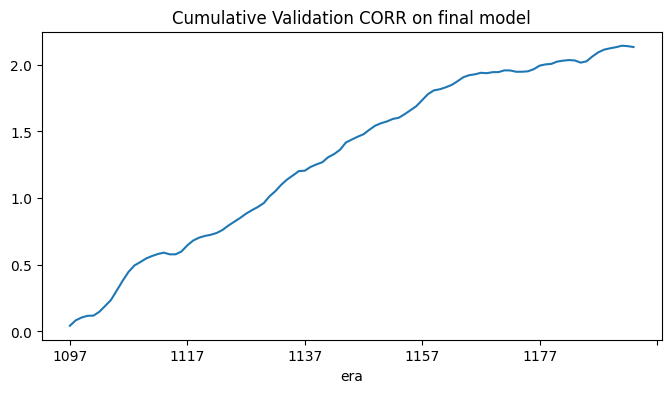

In [17]:
per_era_corr = evaluate_prediction(test, "prediction")

per_era_corr.cumsum().plot(
title="Cumulative Validation CORR on final model",
kind="line",
figsize=(8, 4),
legend=False
)

MODEL PERFORMANCE METRICS
Mean:             0.022564
Std:              0.018242
Sharpe:             1.2369
Max Drawdown:     0.015582
Hit Rate:           88.66%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2628
Max Feature Exposure - Std:  0.0152



<Axes: title={'center': 'Cumulative Validation CORR on benchmark model'}, xlabel='era'>

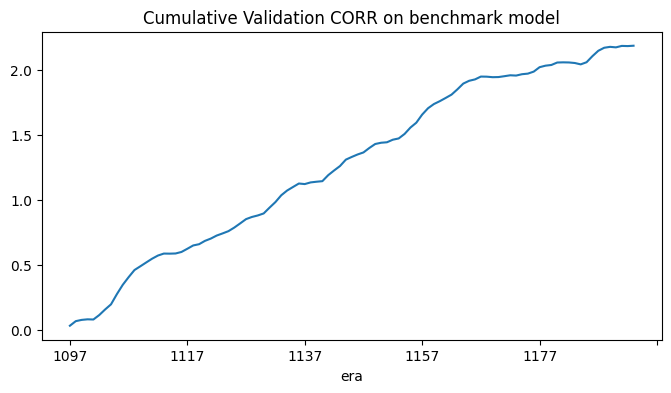

In [18]:
per_era_corr = evaluate_prediction(test, "benchmark_prediction")

per_era_corr.cumsum().plot(
title="Cumulative Validation CORR on benchmark model",
kind="line",
figsize=(8, 4),
legend=False
)

## Conclusion


Our model has very similar performance to the benchmark model from Numerai.

This makes sense given both models are trained with a very similar algorithm (LightGBM vs XGBoost) and have the same feature set.

We also notice a significant drop in performance in the last eras and a huge gap with the performance from the validation dataset letting us think the features' predictive power is no longer as effective as it used to be.

A hypothesis would be that Numerai included some features later on because they actually had good performance on the validation dataset.